В текущем ноутбуке я поряботаю с визуализацией обработанных данных. Это поможет:
- интуитивно понимать паттерны данных лучше
- определить, какие визуализации возможны при построении дашборода в Power BI

In [1]:
!git clone https://github.com/Artem1s1337/hr_analytics.git

Cloning into 'hr_analytics'...
remote: Enumerating objects: 249, done.
remote: Counting objects: 100% (249/249), done.
remote: Compressing objects: 100% (208/208), done.
remote: Total 249 (delta 101), reused 156 (delta 35), pack-reused 0 (from 0)
Receiving objects: 100% (249/249), 15.57 MiB | 22.81 MiB/s, done.
Resolving deltas: 100% (101/101), done.


In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import wordcloud as wc

In [56]:
df = pd.read_csv('/content/hr_analytics/data/processed/processed.csv')

In [57]:
df.head()

,id,name,salary_from,salary_to,currency,role,city,fmt,experience,employer,date,key_skills,grade
0,126817560,Бизнес-аналитик,135000.0,180000.0,RUR,Бизнес-аналитик,Москва,в офисе,от 3 до 6 лет,KAMAZ DIGITAL,2025-10-22,"['Бизнес-анализ', 'BPMN', 'SQL', 'Анализ бизне...",middle+/senior
1,126825698,Аналитик,110000.0,250000.0,RUR,"BI-аналитик, аналитик данных",Москва,гибрид,от 3 до 6 лет,VK,2025-10-22,"['SQL', 'Python', 'Power BI', 'Анализ данных',...",middle+/senior
2,126819384,Системный аналитик,130000.0,245000.0,RUR,Системный аналитик,Москва,не указано,от 1 года до 3 лет,КВАРТА ВК,2025-10-22,"['Системный анализ', 'Разработка информационны...",junior+/middle
3,126836677,Аналитик,110000.0,250000.0,RUR,"BI-аналитик, аналитик данных",Москва,гибрид,от 1 года до 3 лет,Иви,2025-10-22,"['SQL', 'Python', 'Power BI', 'Анализ данных',...",junior+/middle
4,126826098,Бизнес-аналитик,135000.0,180000.0,RUR,Бизнес-аналитик,Новосибирск,гибрид,от 1 года до 3 лет,Рокетбанк,2025-10-22,"['Бизнес-анализ', 'BPMN', 'SQL', 'Анализ бизне...",junior+/middle


# Основные графики

In [58]:
df['mid_salary'] = (df['salary_from'] + df['salary_to']) / 2

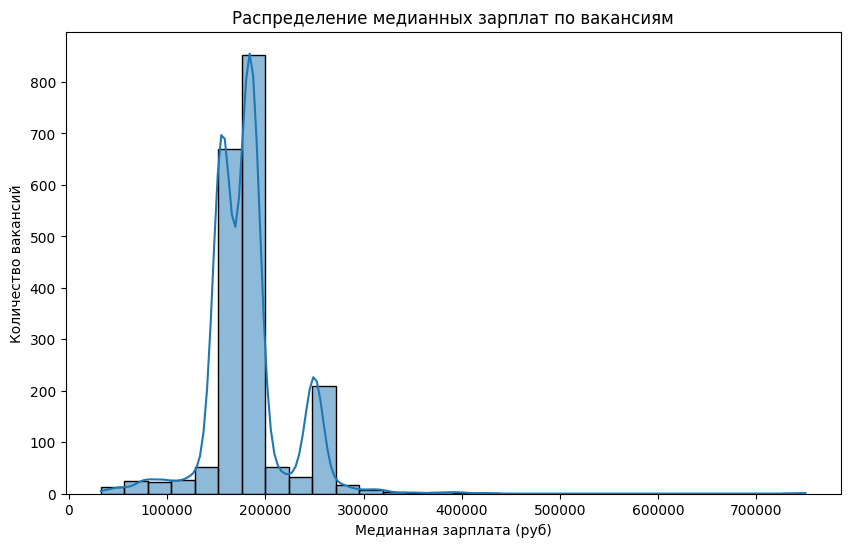

In [59]:
# Отобразим распределение медианных зарплат с плотностью
plt.figure(figsize=(10, 6))
sns.histplot(df['mid_salary'], bins=30, kde=True)
plt.title('Распределение медианных зарплат по вакансиям')
plt.xlabel('Медианная зарплата (руб)')
plt.ylabel('Количество вакансий')
plt.savefig('/content/hr_analytics/images/mid_salary_distribution.jpg')
plt.show()

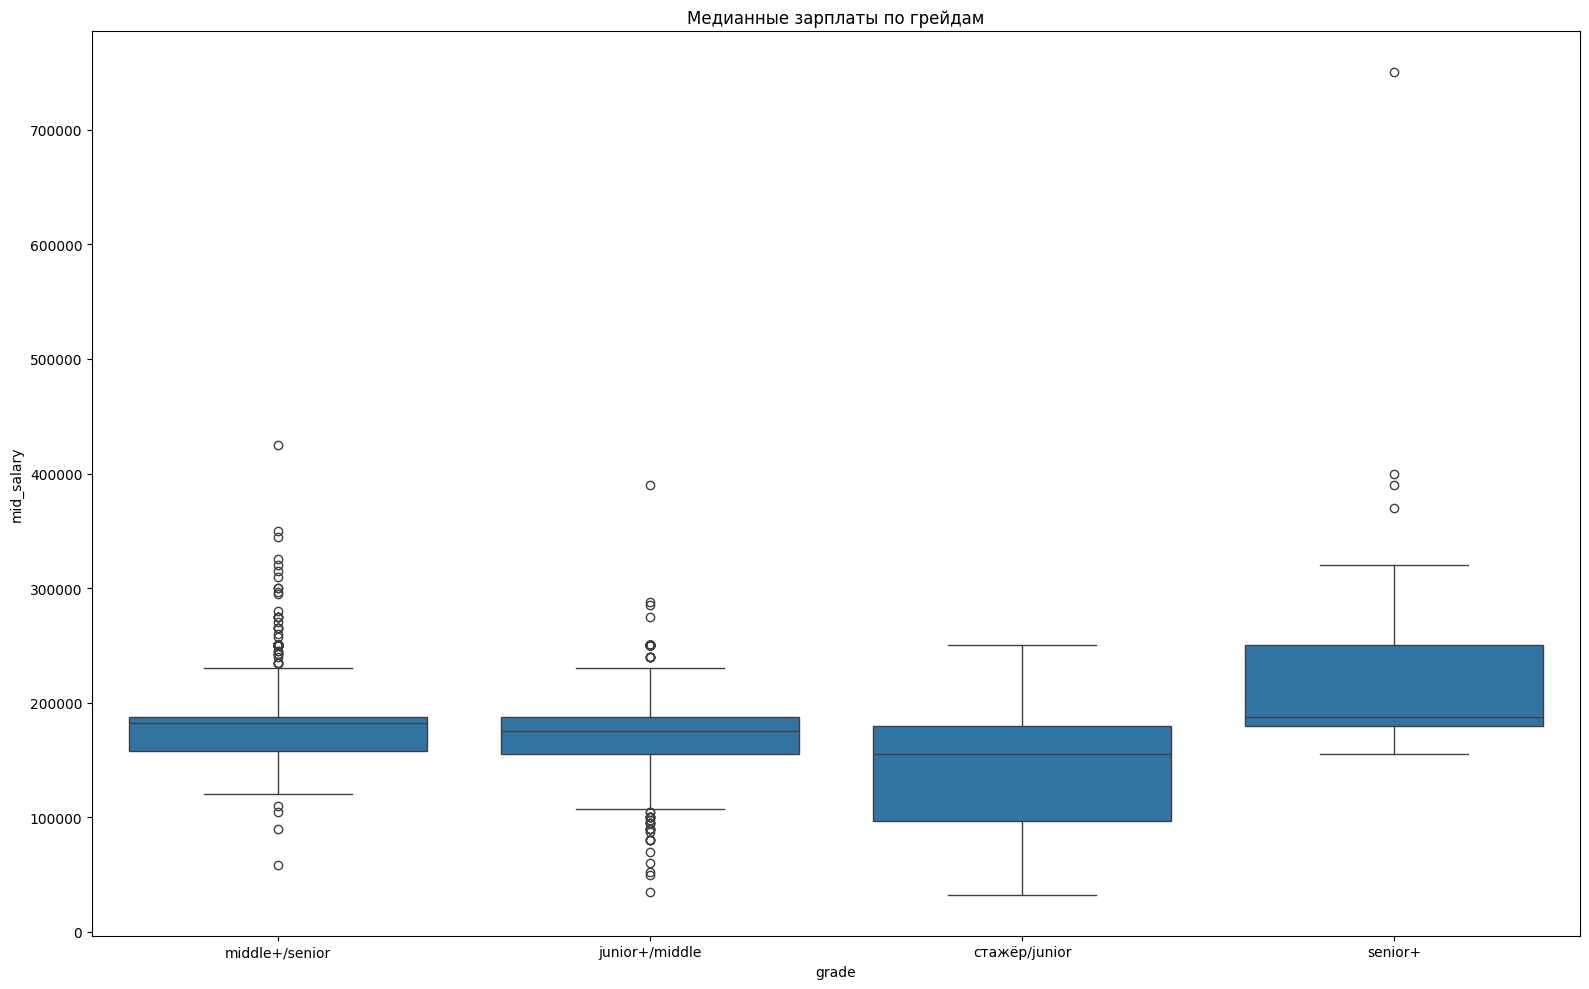

In [60]:
# Быстрое распределение: boxplot, по грейдам и зарплате
plt.figure(figsize=(16, 10))
sns.boxplot(x='grade', y='mid_salary', data=df)
plt.title('Медианные зарплаты по грейдам')
plt.tight_layout()
plt.savefig('/content/hr_analytics/images/mid_salary_by_grades.jpg')
plt.show()

In [61]:
role_group = (
    df.groupby('role')['mid_salary'].agg(
        min_value='min',
        p25_value=lambda s: s.quantile(0.25),
        p50_value='median',
        p75_value=lambda s: s.quantile(0.75),
        max_value='max',
    )
)
role_group

,min_value,p25_value,p50_value,p75_value,max_value
role,,,,,
"BI-аналитик, аналитик данных",50000.0,180000.0,180000.0,180000.0,425000.0
Аналитик,32500.0,155000.0,155000.0,155000.0,350000.0
Бизнес-аналитик,40000.0,157500.0,157500.0,157500.0,370000.0
Дата-сайентист,90000.0,250000.0,250000.0,250000.0,750000.0
Продуктовый аналитик,60000.0,182500.0,182500.0,182500.0,345000.0
Системный аналитик,47500.0,187500.0,187500.0,187500.0,400000.0


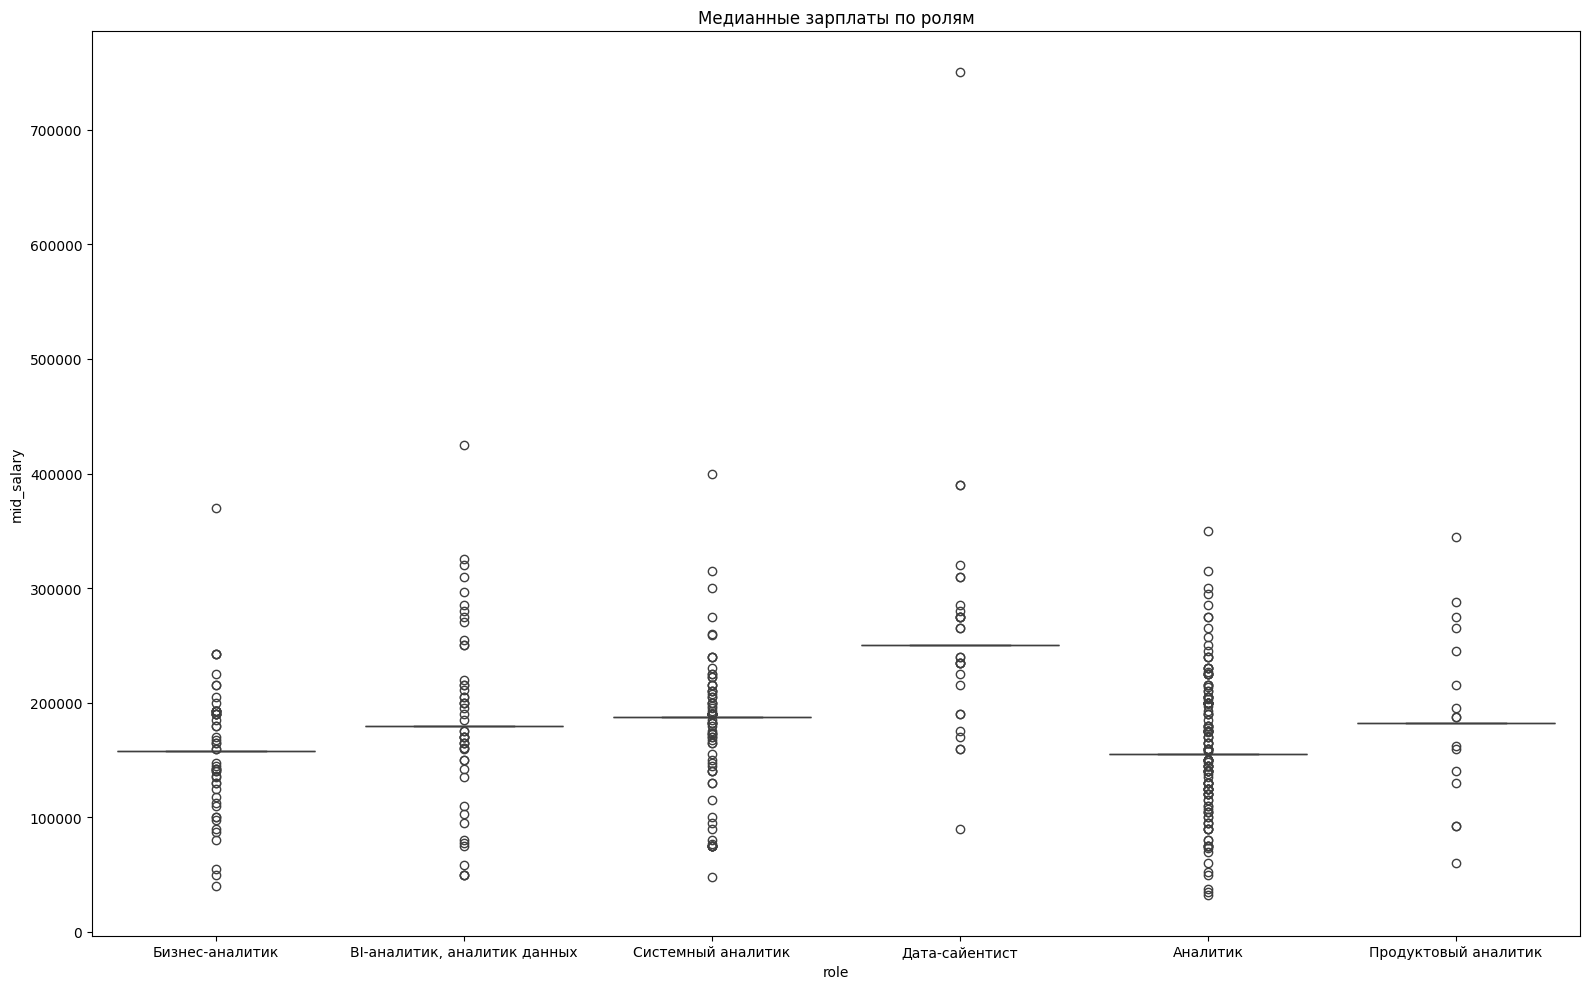

In [62]:
plt.figure(figsize=(16, 10))
sns.boxplot(data=df, x='role', y='mid_salary')
plt.title('Медианные зарплаты по ролям')
plt.tight_layout()
plt.savefig('/content/hr_analytics/images/mid_salary_by_roles.jpg')
plt.show()

Распределение медианной зп показывает два пика, но учитывая, что большинство значений были не заполненны, это значение сильно усреднено. Ящики с усами показывают, что самый большой размах медианных зарплат у джуниор и стажёрских позиций: от <100к до 100к+. У мидлов, мидл+ и сеньоров более стабильные вилки, а вот у сеньор+ (и это уже, скорее всего, менеджмент: разброс идёт вверх за 250к+

По ролям видно, что самые высокие зарплаты у дата-саентистов и продуктовых аналитиков. Затем идут все остальные

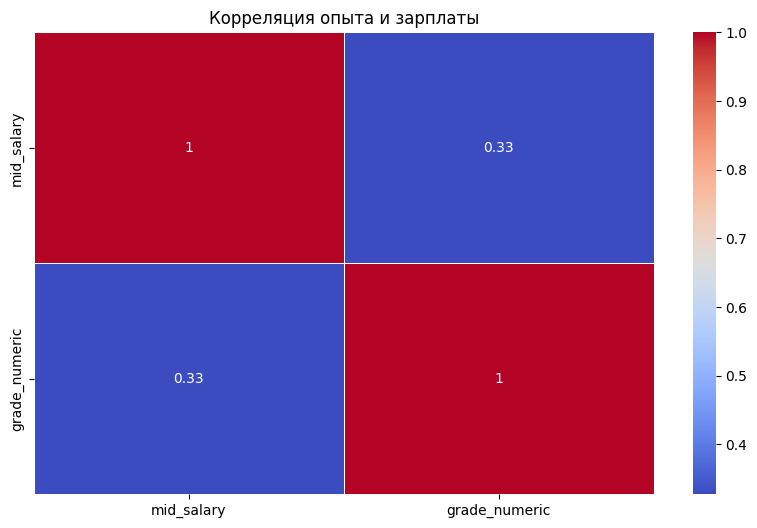

In [63]:
# Дополнительно можно построить scatter plot и heatmap на основе корреляционной матрицы
# Это дополнительно покажет линейную связь опыта и зарплаты
# Привести grade к числовым значениям можно разными способами. Воспользуемся маппером
grade_num = {
    'стажёр/junior': 1,
    'junior+/middle': 2,
    'middle+/senior': 3,
    'senior+': 4,
}
df['grade_numeric'] = df['grade'].map(grade_num)
matrix = df[['mid_salary', 'grade_numeric']].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(matrix, annot=True, cmap='coolwarm', linewidth=0.5)
plt.title('Корреляция опыта и зарплаты')
plt.savefig('/content/hr_analytics/images/exp_salary_correlation.jpg')
plt.show()

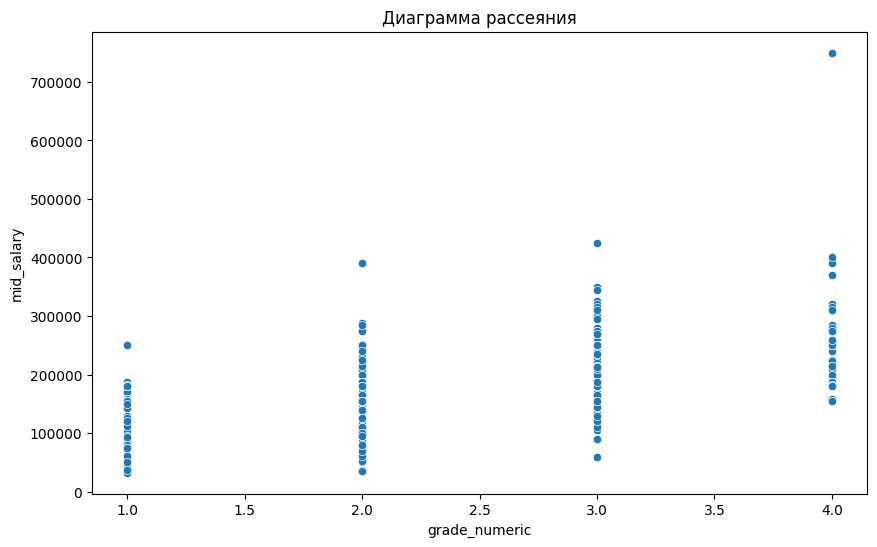

In [64]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='grade_numeric', y='mid_salary')
plt.title('Диаграмма рассеяния')
plt.savefig('/content/hr_analytics/images/grade_salary_scatter.jpg')
plt.show()

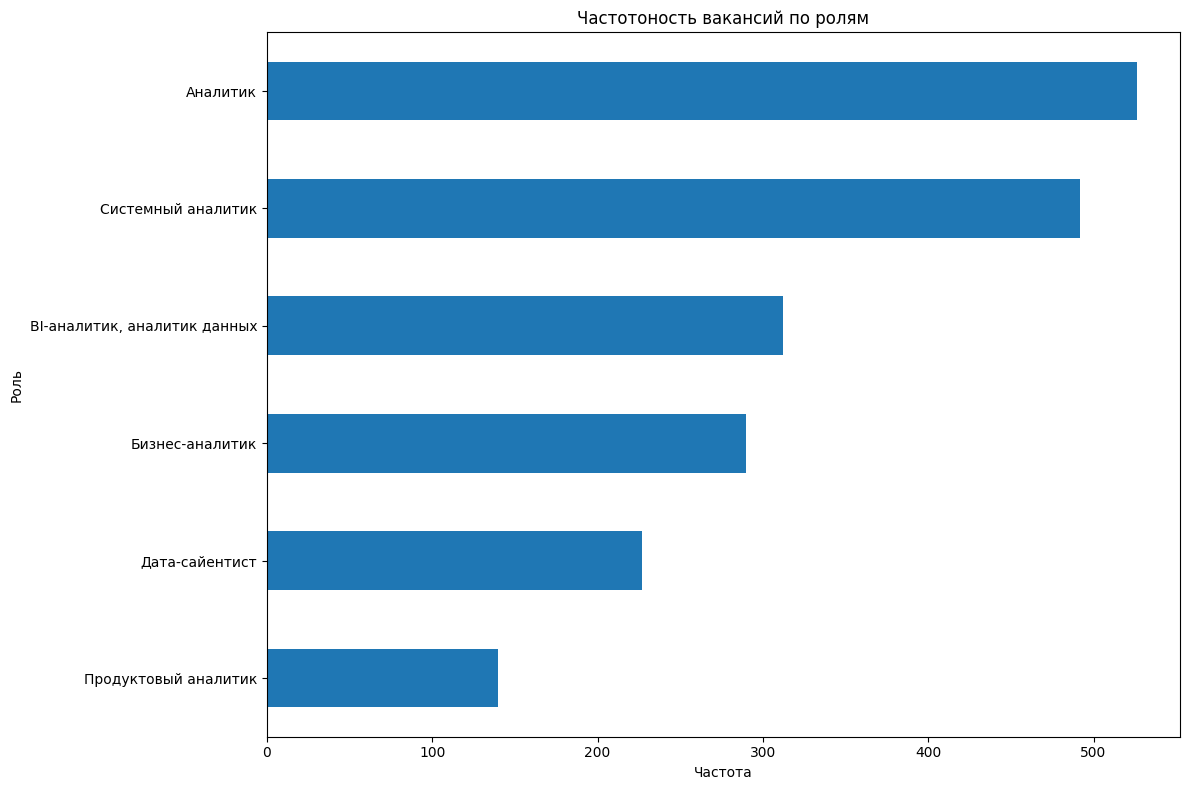

In [65]:
# Простые barplot по категориальным переменным
plt.figure(figsize=(12, 8))
df['role'].value_counts().sort_values(ascending=True).plot(kind='barh')
plt.title('Частотоность вакансий по ролям')
plt.ylabel('Роль')
plt.xlabel('Частота')
plt.tight_layout()
plt.savefig('/content/hr_analytics/images/freq_by_role.jpg')
plt.show()

Топ-3: аналитики, системные аналитик и BI-аналитики по количеству вакансий

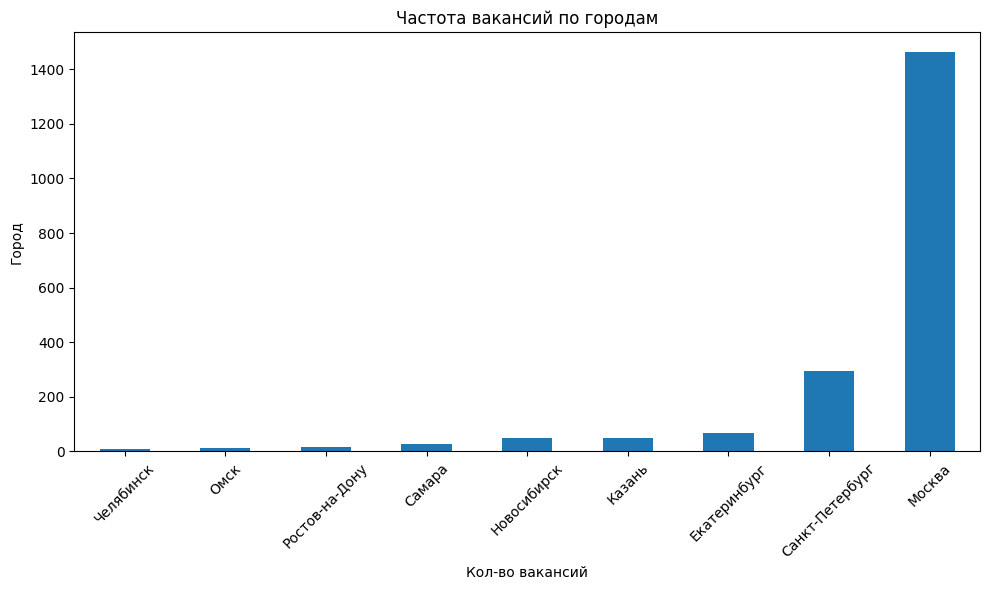

In [66]:
# Частотность по городам - связь прямо пропорциональная населению
plt.figure(figsize=(10, 6))
df['city'].value_counts().sort_values(ascending=True).plot(kind='bar')
plt.title('Частота вакансий по городам')
plt.ylabel('Город')
plt.xlabel('Кол-во вакансий')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('/content/hr_analytics/images/freq_by_cities.jpg')
plt.show()

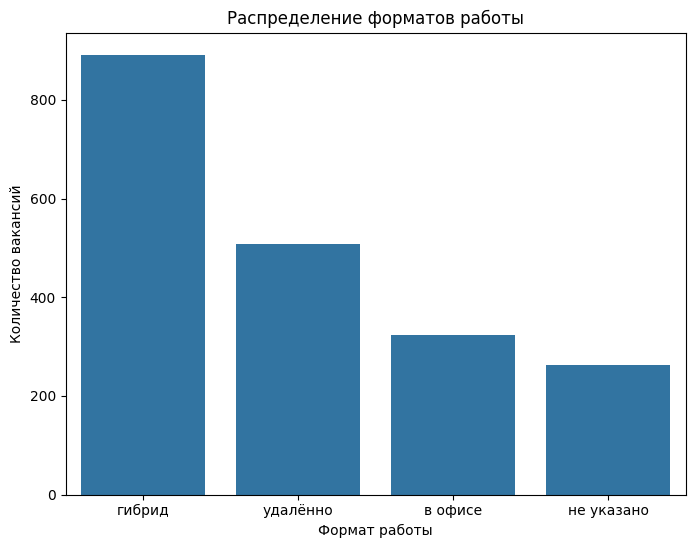

In [67]:
# Формат работы
plt.figure(figsize=(8, 6))
work_counts = df['fmt'].value_counts()
sns.barplot(x=work_counts.index, y=work_counts.values)
plt.title('Распределение форматов работы')
plt.xlabel('Формат работы')
plt.ylabel('Количество вакансий')
plt.savefig('/content/hr_analytics/images/work_format_dist.jpg')
plt.show()

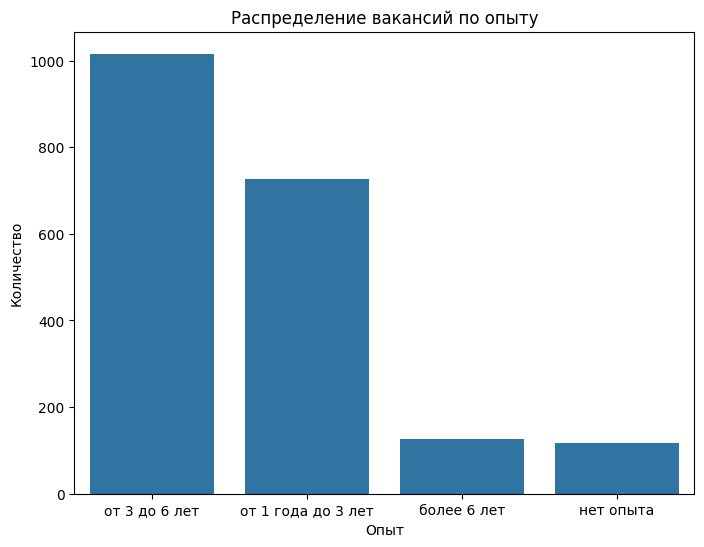

In [68]:
# Распределение опыта
plt.figure(figsize=(8, 6))
exp_counts = df['experience'].value_counts()
sns.barplot(x=exp_counts.index, y=exp_counts.values)
plt.title('Распределение вакансий по опыту')
plt.xlabel('Опыт')
plt.ylabel('Количество')

plt.savefig('/content/hr_analytics/images/exp_dist.jpg')
plt.show()

# Дополнительные графики (сводка, группировка)

<Figure size 1600x1000 with 0 Axes>

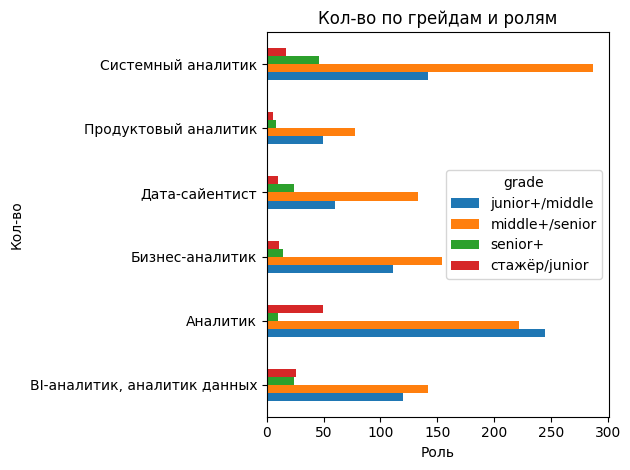

In [69]:
crosstab = pd.crosstab(df['role'], df['grade'])
plt.figure(figsize=(16, 10))
crosstab.plot(kind='barh')
plt.title('Кол-во по грейдам и ролям')
plt.ylabel('Кол-во')
plt.xlabel('Роль')
plt.tight_layout()
plt.savefig('/content/hr_analytics/images/group_by_grades_n_roles.jpg')
plt.show()

Мидл-специалисты превалируют везде, кроме аналитиков

<Figure size 1600x1000 with 0 Axes>

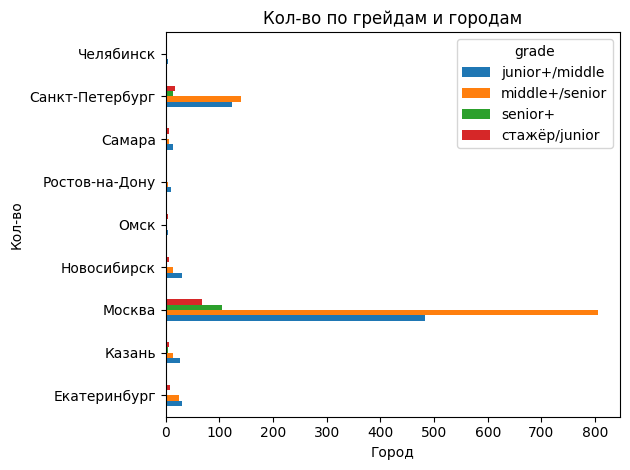

In [70]:
crosstab = pd.crosstab(df['city'], df['grade'])
plt.figure(figsize=(16, 10))
crosstab.plot(kind='barh')
plt.title('Кол-во по грейдам и городам')
plt.ylabel('Кол-во')
plt.xlabel('Город')
plt.tight_layout()
plt.savefig('/content/hr_analytics/images/group_by_grades_n_cities.jpg')
plt.show()

Москва и Санкт-Петербург сильно доминируют по количеству вакансий

In [71]:
import ast

def str_to_list(text):
  return ast.literal_eval(text)

df['key_skills'] = df['key_skills'].apply(str_to_list)

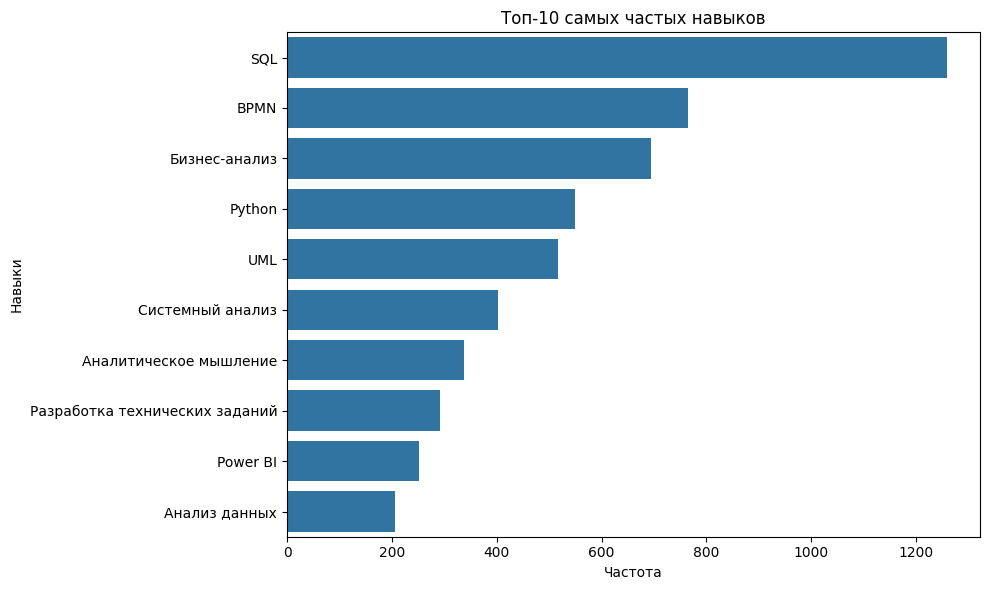

In [72]:
# Топ-10 навыков
all_skills = [skill for skills in df['key_skills'] for skill in skills]
counter = Counter(all_skills).most_common(10)

plt.figure(figsize=(10, 6))
skills, counts = zip(*counter)
sns.barplot(x=list(counts), y=list(skills))
plt.title('Топ-10 самых частых навыков')
plt.xlabel('Частота')
plt.ylabel('Навыки')
plt.tight_layout()
plt.savefig('/content/hr_analytics/images/top_ten_skills.jpg')
plt.show()

Cамые распространённые технические скиллы:
1. SQL
2. BPMN/UML
3. Python
4. Power BI

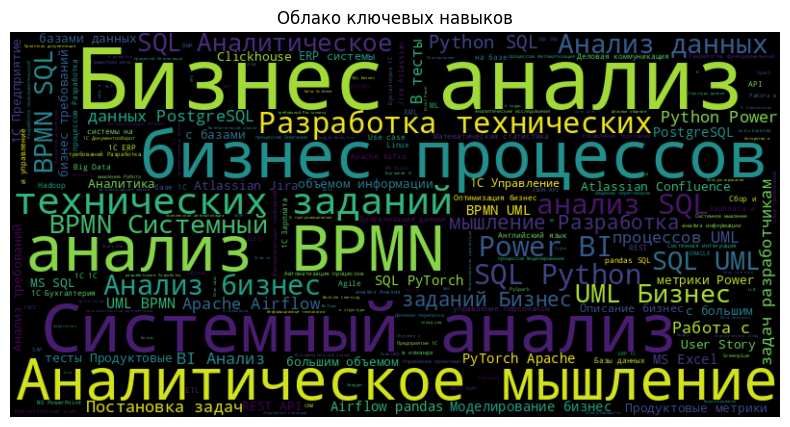

In [73]:
# Облако слов
text = ' '.join(all_skills)
wordcloud = wc.WordCloud(width=800, height=400, background_color='black').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Облако ключевых навыков')
plt.savefig('/content/hr_analytics/images/key_skills_wordcloud.jpg')
plt.show()

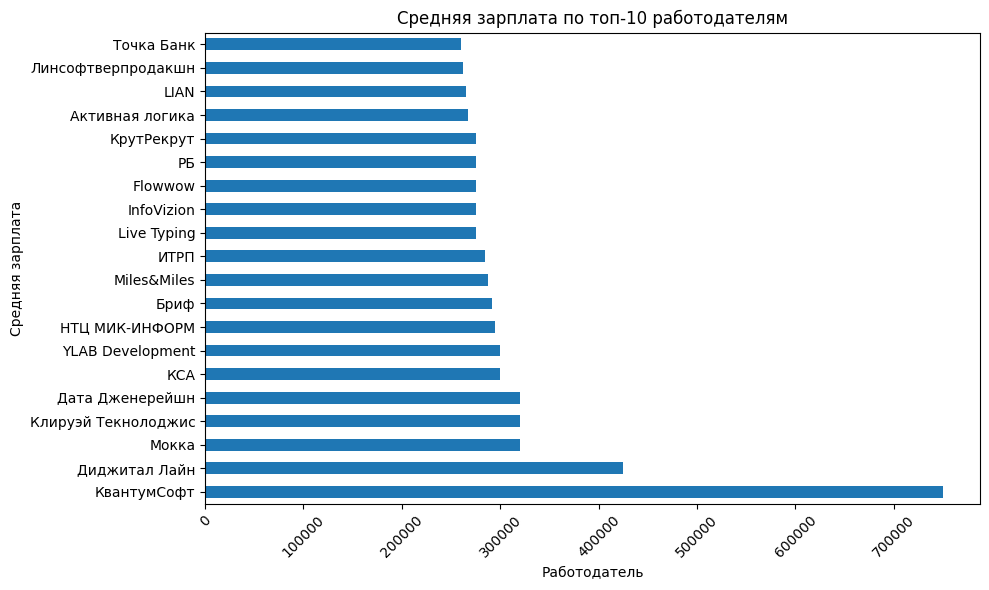

In [74]:
# Сравнение зарплат по работодателям
top_employers = df.groupby('employer')['mid_salary'].mean().sort_values(ascending=False).head(20)
plt.figure(figsize=(10, 6))
top_employers.plot(kind='barh')
plt.title('Средняя зарплата по топ-10 работодателям')
plt.xlabel('Работодатель')
plt.ylabel('Средняя зарплата')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('/content/hr_analytics/images/mid_salary_by_top_ten_employers.jpg')
plt.show()

Это не самая показательная статистика, т.к. работодатель может опубликовать мало вакансий с высокой зарплатой, что даст ему место в топе

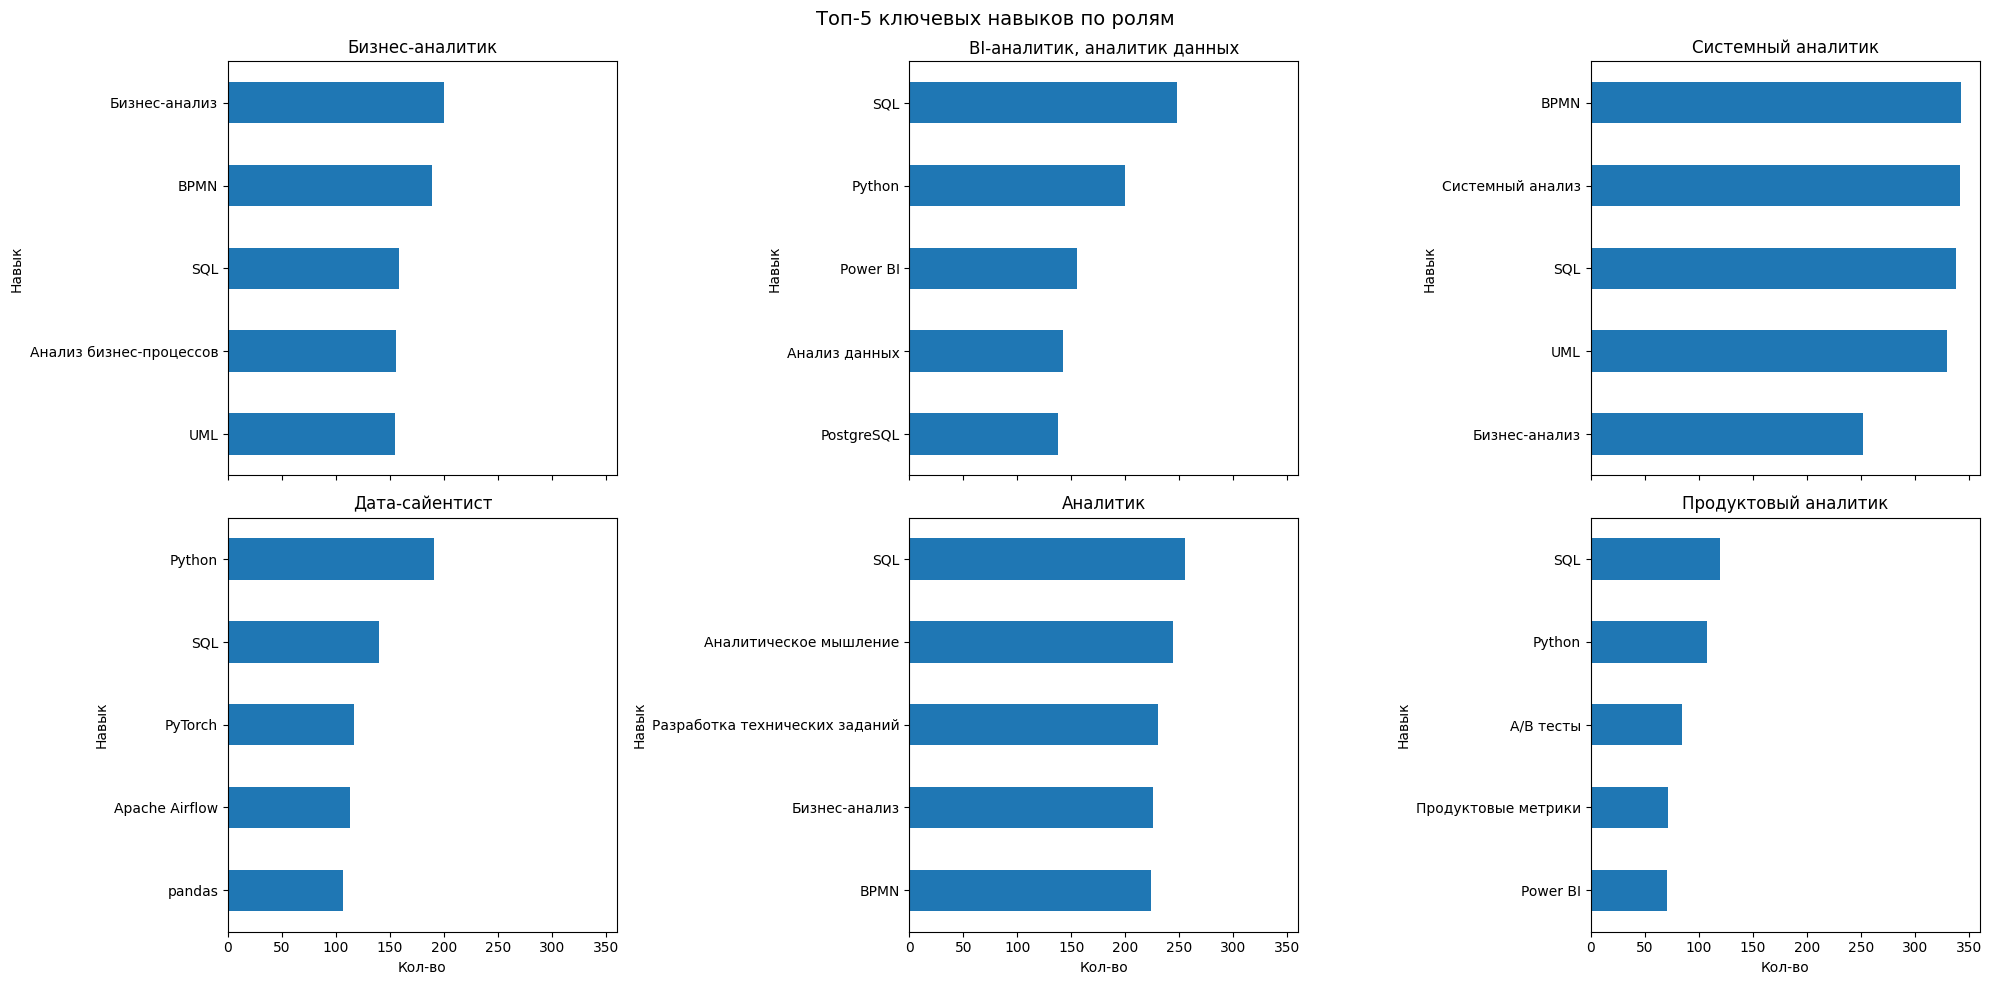

In [105]:
# Топ-5 навыков по каждой из ролей
roles = df['role'].unique().tolist()

fig, axes = plt.subplots(2, 3, figsize=(20, 10), sharex=True)
axes = axes.flatten()

for i, role in enumerate(roles):
    sub = df[df['role'] == role]
    counts = (sub['key_skills']
              .explode()
              .value_counts()
              .head(5)
              .sort_values(ascending=True))
    counts.plot(kind='barh', ax=axes[i])  # важен ax для конкретной панели
    axes[i].set_title(role)
    axes[i].set_ylabel('Навык')
    axes[i].set_xlabel('Кол-во')

fig.suptitle('Топ‑5 ключевых навыков по ролям', fontsize=14, y=0.98)

plt.tight_layout()
plt.savefig('/content/hr_analytics/images/top_five_skills_by_role.jpg')
plt.show()